In [11]:
import math
import matplotlib as mpl
from matplotlib import cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tifffile
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
import shutil


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import make_scorer, accuracy_score
#from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import curve_fit

# Problem Description

This is a binary image classification problem. Specifically, the goal is train an image classifier to identify metastatic cancer, using the supplied images in the training data set. The data set consists of 96 x 96 pixel, 3 channel .tif images. There are 220k images in the training data set and 57.5k images in the validation data set.

# EDA

### Data Inspection

In [12]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

In [13]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


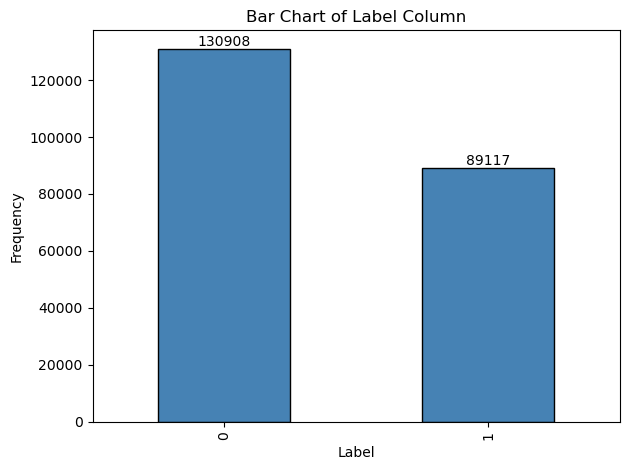

In [14]:
label_counts = labels['label'].value_counts()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the bar chart
label_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')

# Set the title and axis labels
ax.set_title('Bar Chart of Label Column')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')

# Add value labels on top of each bar
for i, v in enumerate(label_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

fig.tight_layout()
plt.show()

In [15]:
data = labels

# Check for empty values
empty_columns = data.columns[data.isnull().all()]
print("Empty columns:", empty_columns)

# Check for null values
null_columns = data.columns[data.isnull().any()]
print("Null columns:", null_columns)

# Check for NaN values
nan_columns = data.columns[data.isna().any()]
print("NaN columns:", nan_columns)

# Check for missing values
missing_columns = data.columns[data.isnull().any() | data.isna().any()]
print("Missing value columns:", missing_columns)

Empty columns: Index([], dtype='object')
Null columns: Index([], dtype='object')
NaN columns: Index([], dtype='object')
Missing value columns: Index([], dtype='object')


### Image File Properties 

In [16]:
#Print image metadata
image_path = '/kaggle/input/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif'
image = tifffile.imread(image_path)

print("Image Shape:", image.shape)
print("Image Width:", image.shape[1])
print("Image Height:", image.shape[0])
print("Image Channels:", image.shape[2] if len(image.shape) > 2 else 1)

with tifffile.TiffFile(image_path) as tif:
    metadata = tif.pages[0].tags
    print("\nMetadata:")
    for tag in metadata.values():
        print(tag)

Image Shape: (96, 96, 3)
Image Width: 96
Image Height: 96
Image Channels: 3

Metadata:
TiffTag 254 NewSubfileType @10 LONG @18 = UNDEFINED
TiffTag 256 ImageWidth @22 LONG @30 = 96
TiffTag 257 ImageLength @34 LONG @42 = 96
TiffTag 258 BitsPerSample @46 SHORT[3] @194 = (8, 8, 8)
TiffTag 259 Compression @58 SHORT @66 = NONE
TiffTag 262 PhotometricInterpretation @70 SHORT @78 = RGB
TiffTag 270 ImageDescription @82 ASCII[23] @200 = {"shape": [96, 96, 3]}
TiffTag 273 StripOffsets @94 LONG @102 = (287,)
TiffTag 277 SamplesPerPixel @106 SHORT @114 = 3
TiffTag 278 RowsPerStrip @118 LONG @126 = 96
TiffTag 279 StripByteCounts @130 LONG @138 = (27648,)
TiffTag 284 PlanarConfiguration @142 SHORT @150 = CONTIG
TiffTag 305 Software @154 ASCII[12] @255 = tifffile.py
TiffTag 306 DateTime @166 ASCII[20] @267 = 2018:11:15 17:21:33
TiffTag 339 SampleFormat @178 SHORT @186 = UINT


### Example Images

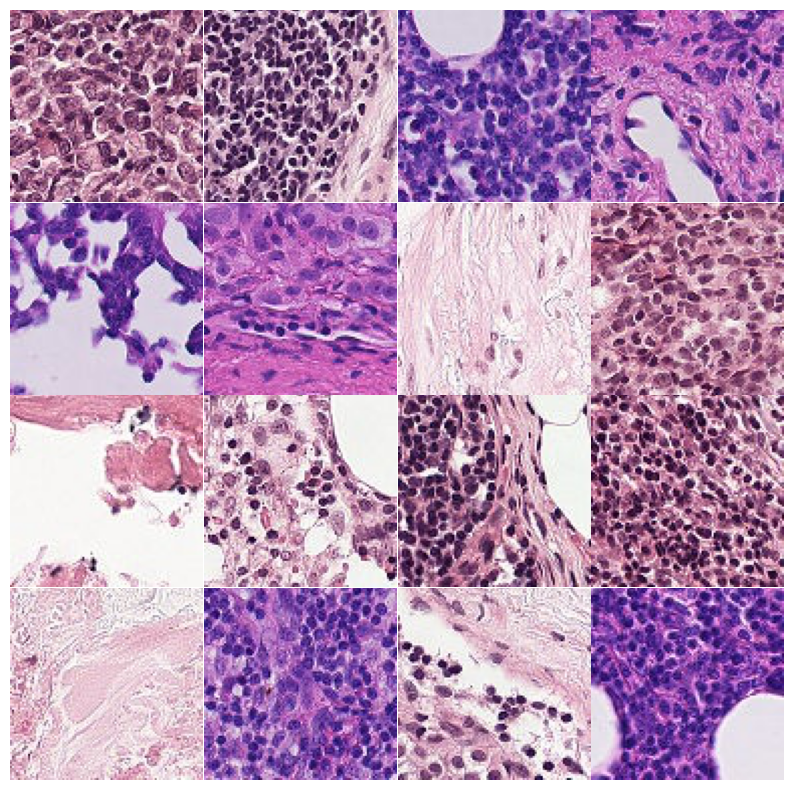

In [17]:
directory = '/kaggle/input/histopathologic-cancer-detection/test'

# Create a figure and axes
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Disable spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate over the images in the directory
for i, filename in enumerate(os.listdir(directory)[:16]):
    if i >= 16:
        break

    # Load the image
    img = mpimg.imread(os.path.join(directory, filename))

    # Plot the image
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].axis('off')

# Display the plot
plt.show()

In [18]:
#IMAGE_SIZE = 96
#IMAGE_CHANNELS = 3
#SAMPLE_SIZE = 500
#set global variables
img_size = 96
img_channels = 3
sample_size = 2000

In [19]:
#Helper functions
def remove_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Directory '{directory}' removed successfully.")
    else:
        print(f"Directory '{directory}' does not exist.")
        
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

In [90]:
def delete_folder_contents(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            delete_folder_contents(dir_path)
            os.rmdir(dir_path)

# Call the function to delete the contents of the folder
#delete_folder_contents('/kaggle/working/')

In [50]:
#prepare folders in working directory
create_dir('./train')
create_dir('./train/0')
create_dir('./train/1')

create_dir('./val')
create_dir('./val/0')
create_dir('./val/1')

create_dir('./test')
create_dir('./test/0')

Directory './train' created successfully.
Directory './train/0' created successfully.
Directory './train/1' created successfully.
Directory './val' created successfully.
Directory './val/0' created successfully.
Directory './val/1' created successfully.
Directory './test' created successfully.
Directory './test/0' created successfully.


In [46]:
def copy_imgs(input_dir, output_dir, labels):
    i = 0
    for index, row in labels.iterrows():
        if i >= sample_size:
            break

        image_name = row['id'] + '.tif'
        image_label = row['label']
        source_path = os.path.join(input_dir, image_name)
        destination_path = os.path.join(output_dir, str(image_label))

        if not os.path.exists(destination_path):
            os.makedirs(destination_path)

        shutil.copy(source_path, destination_path)

        i += 1

In [51]:
#move data to working directories
input_dir = '../input/histopathologic-cancer-detection/train'
train_dir = './train'
val_dir = './val'
labels_0 = labels[labels['label'] == 0].copy()
labels_1 = labels[labels['label'] == 1].copy()

copy_imgs(input_dir, train_dir, labels_0.sample(n=sample_size, replace = True))
copy_imgs(input_dir, train_dir, labels_1.sample(n=sample_size, replace = True))
copy_imgs(input_dir, val_dir, labels_0.sample(n=sample_size, replace = True))
copy_imgs(input_dir, val_dir, labels_1.sample(n=sample_size, replace = True))

In [52]:
# Set the paths to the training and validation directories
#train_dir = './train'
#val_dir = './val'

# Create the ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load the training and validation data
train_data = train_datagen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=32, class_mode='binary')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=32, class_mode='binary')

Found 3968 images belonging to 2 classes.
Found 3950 images belonging to 2 classes.


In [54]:
test_list = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/test', fname)
    dst = os.path.join('./test/0', fname)
    shutil.copyfile(src, dst)

In [58]:
test_path ='/kaggle/working/test'


# Here we change the path to point to the test_images folder.

test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(test_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


# Modeling 

### Architecture

I will be using the convolutional neural network (CNN) architecture to train various models on this data with the goal of accurately determining the presence of metastatic cancer. CNNs generally consist of several different types of layers: convolutional, pooling, and fully connected. The first two types or layers are used to extract features from the data, and can vary in scope to capture either small details or large, whole-image features. The final, fully connected layer is then used as a classifier to produce the desired output.

CNNs are well suited to processing image data because they work on grid-based information. They have a number of properties that are desirable for processing images, such as scale and translational invariance, which allow them to identify features that may be stretched or rotated when compared to the reference feature. 

I will vary the number, size, and type of layers, their relative configurations, and the activation functions in order to see what effect each of these parameters has on model accuracy.

### Models

In [93]:
#model 1
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history1 = model.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 10, 10, 128)    

In [94]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on validation data
loss, accuracy = model.evaluate(val_data)

# Print the evaluation results
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)

376/376 [==============================] - 13s 34ms/step - loss: 0.6508 - accuracy: 0.5517
Validation Loss: 0.6508025527000427
Validation Accuracy: 0.5516839623451233


In [95]:
#model 2
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# Flatten the output
model2.add(Flatten())

# Add fully connected layers
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

# Train the model
history2 = model2.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 10, 10, 128)    

In [96]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on validation data
loss2, accuracy2 = model2.evaluate(val_data)

# Print the evaluation results
print('Validation Loss:', loss2)
print('Validation Accuracy:', accuracy2)

376/376 [==============================] - 13s 34ms/step - loss: 0.6355 - accuracy: 0.6363
Validation Loss: 0.6355454325675964
Validation Accuracy: 0.6362577676773071


In [97]:
#model 3
model3 = Sequential()

# Add convolutional layers
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# Flatten the output
model3.add(Flatten())

# Add fully connected layers
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()

# Train the model
history3 = model3.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 10, 10, 64)     

In [98]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on validation data
loss3, accuracy3 = model3.evaluate(val_data)

# Print the evaluation results
print('Validation Loss:', loss3)
print('Validation Accuracy:', accuracy3)

376/376 [==============================] - 14s 35ms/step - loss: 0.6994 - accuracy: 0.4975
Validation Loss: 0.6993928551673889
Validation Accuracy: 0.4974636137485504


In [59]:
#model 4
model4 = Sequential()

# Add convolutional layers
model4.add(Conv2D(32, (3, 3), activation='selu', input_shape=(96, 96, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(64, (3, 3), activation='selu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Conv2D(128, (3, 3), activation='selu'))
model4.add(MaxPooling2D((2, 2)))

# Flatten the output
model4.add(Flatten())

# Add fully connected layers
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model4.summary()

# Train the model
history4 = model4.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)     

In [62]:
model4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on validation data
loss4, accuracy4 = model4.evaluate(val_data)

# Print the evaluation results
print('Validation Loss:', loss4)
print('Validation Accuracy:', accuracy4)

124/124 [==============================] - 5s 33ms/step - loss: 0.9706 - accuracy: 0.7461
Validation Loss: 0.9706099033355713
Validation Accuracy: 0.7460759282112122


In [101]:
#model 5
model5 = Sequential()

# Add convolutional layers
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model5.add(Conv2D(32, (3, 3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2))) 

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

# Flatten the output
model5.add(Flatten())

# Add fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model5.summary()

# Train the model
history5 = model5.fit(train_data, validation_data=val_data, epochs=10)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_84 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 46, 46, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 conv2d_86 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 21, 21, 64)       0         
 g2D)                                                

In [106]:
model5.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on validation data
loss5, accuracy5 = model5.evaluate(val_data)

# Print the evaluation results
print('Validation Loss:', loss5)
print('Validation Accuracy:', accuracy5)

376/376 [==============================] - 13s 34ms/step - loss: 0.6932 - accuracy: 0.4975
Validation Loss: 0.6931585669517517
Validation Accuracy: 0.4974636137485504


# Results

In [107]:
def plot_history(history, model):
    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    validation_accuracy = history.history['val_accuracy']
    validation_loss = history.history['val_loss']

    # Nonlinear function for best fit line
    def nonlinear_func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    # Plot the training history
    epochs = range(1, len(training_accuracy) + 1)

    # Plot the training history
    plt.figure(figsize=(12, 6))

    # Plot training accuracy with best fit line
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, marker='o', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, marker='o', label='Validation Accuracy')
    #plt.plot(epochs, nonlinear_func(epochs, *popt_acc), '--', label='Best Fit Line')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot training loss with best fit line
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, marker='o', label='Training Loss')
    plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
    #plt.plot(epochs, nonlinear_func(epochs, *popt_loss), '--', label='Best Fit Line')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle('Model Performance Comparison - ' + model)
    plt.tight_layout()
    plt.show()

### Accuracy by Epoch

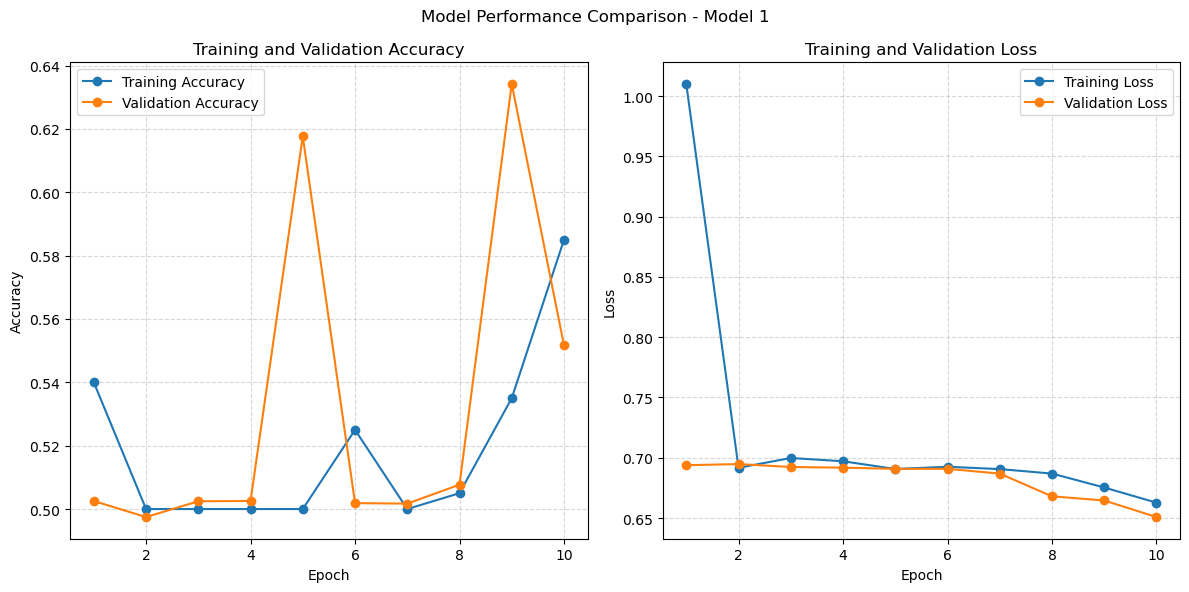

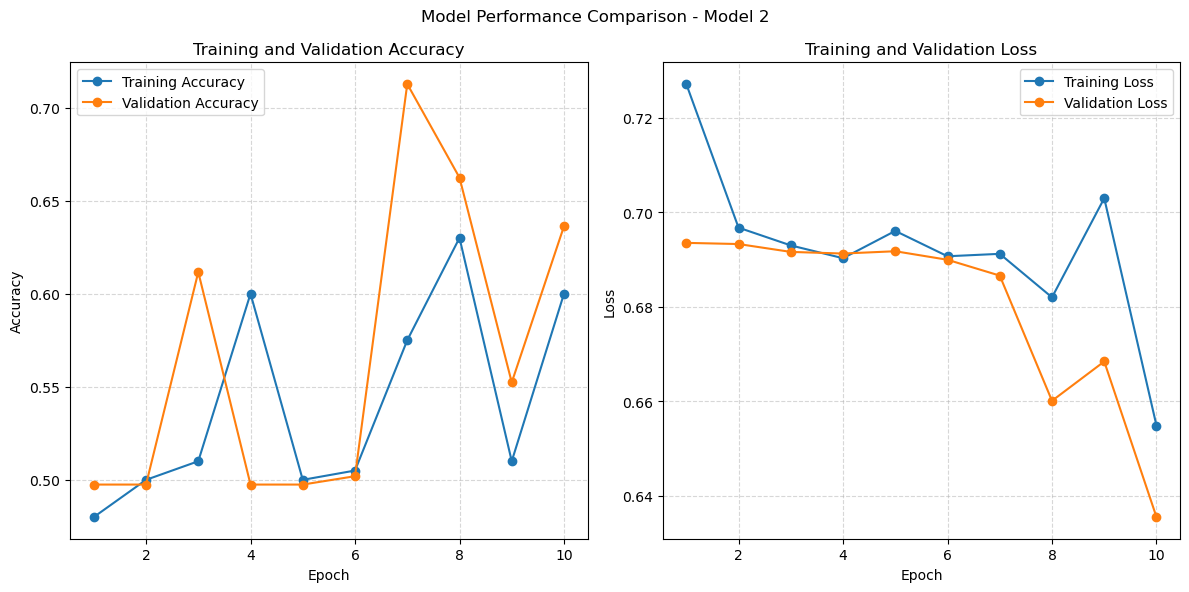

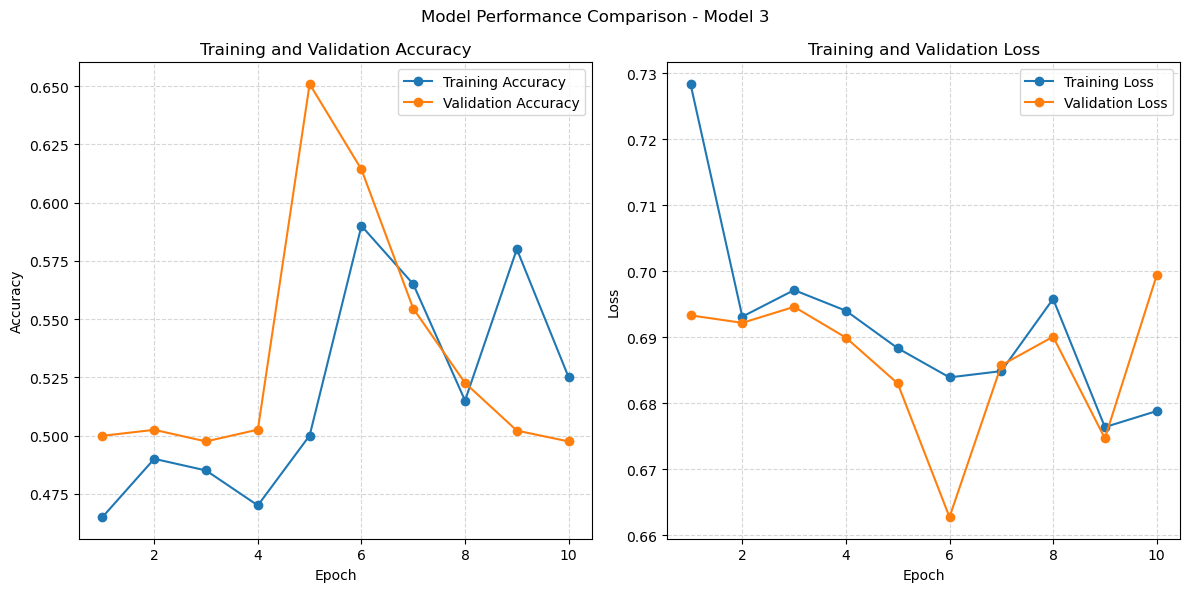

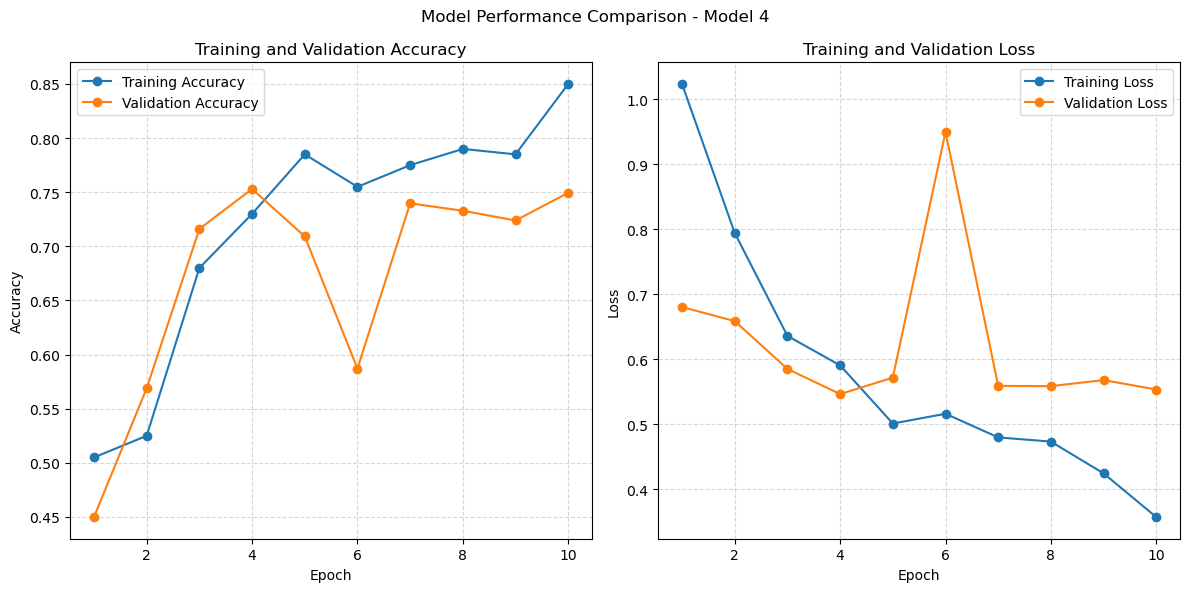

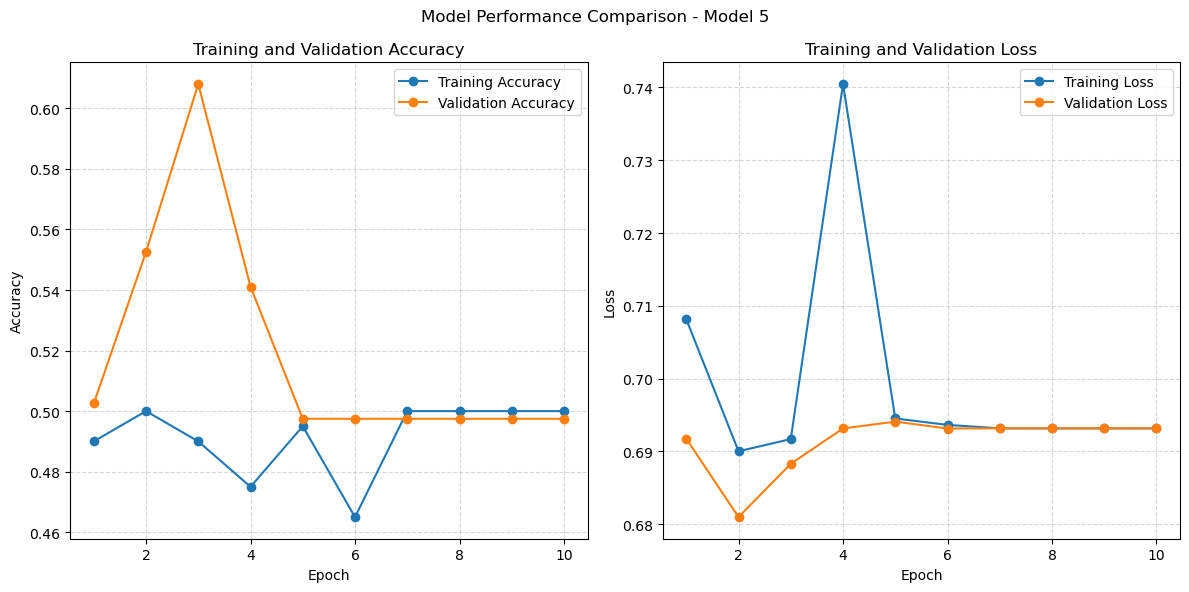

In [108]:
plot_history(history1, 'Model 1')
plot_history(history2, 'Model 2')
plot_history(history3, 'Model 3')
plot_history(history4, 'Model 4')
plot_history(history5, 'Model 5')

### Comparative Accuracy

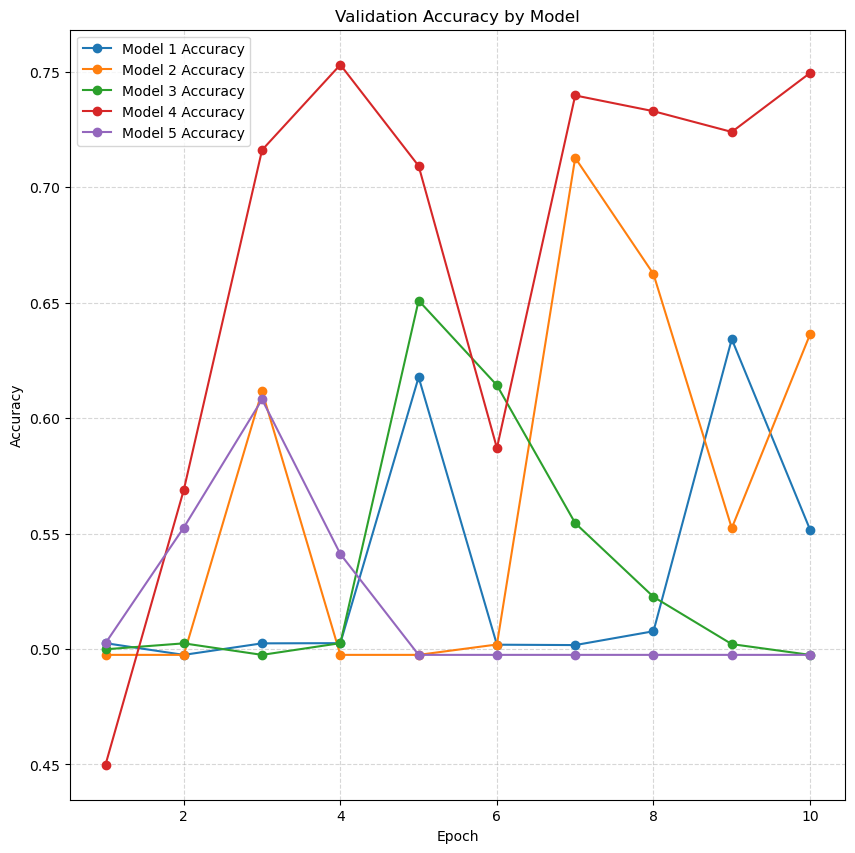

In [109]:
# Plot the accuracy history of all models
training_accuracy1 = history1.history['val_accuracy']
training_accuracy2 = history2.history['val_accuracy']
training_accuracy3 = history3.history['val_accuracy']
training_accuracy4 = history4.history['val_accuracy']
training_accuracy5 = history5.history['val_accuracy']

epochs = range(1, len(training_accuracy1) + 1)
#plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, training_accuracy1, marker='o', label='Model 1 Accuracy')
plt.plot(epochs, training_accuracy2, marker='o', label='Model 2 Accuracy')
plt.plot(epochs, training_accuracy3, marker='o', label='Model 3 Accuracy')
plt.plot(epochs, training_accuracy4, marker='o', label='Model 4 Accuracy')
plt.plot(epochs, training_accuracy5, marker='o', label='Model 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Conclusion



Model 4 turned out to be the most accurate, achieving a validation accuracy of roughly 75%. Some parameter changes did not seem to affect model accuracy, and may even have hurt it. Increased training time, for example, had little effect on validation accuracy after about 7 epochs, and in some cases led to over fitting, as indicated by increase training accuracy but flat or decreased validation accuracy. Adding duplicate convolutional layers without intervening pooling layers, as with model 5, lead to very low performance.

The parameters that did help appear to be an extra fully connected layer as part of the classifier and a variety of sizes for the convolutional layer. The former makes sense, as it is unlikely that the convolutional layers would extract the features so efficiently that a single layer would be sufficient to classify their output. The latter also makes sense, as different sizes of convolutional layers allow the model to 'see' fine-grained details as well as features that span large parts of the image.

The easiest future improvement would just be training on a larger data set. As I was developing these models, I was training them on smaller data sets to speed up processing time, and the accuracy was significantly lower than it is with the current sample size. More experimentation with layer configurations, including different kernel sizes and perhaps stride sizes, could also lead to improvement. 

# Submission

In [96]:
num_test_imgs = len(os.listdir('/kaggle/working/test/0'))
predictions = model4.predict(test_gen, steps=num_test_imgs, verbose=1)

57458/57458 [==============================] - 181s 3ms/step


In [97]:
predictions.shape

(57458, 1)

In [109]:
test_filenames = test_gen.filenames
#test_filenames = [string.lstrip('0/').rstrip('.tif') for string in test_filenames]
test_filenames = [string[2:-4] for string in test_filenames]

In [110]:
df = pd.DataFrame(test_filenames, columns = ['id'])
df.set_index('id', inplace = True)
df['label'] = predictions
df.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,5.188758e-03
0000ec92553fda4ce39889f9226ace43cae3364e,9.985952e-01
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,5.846403e-01
000253dfaa0be9d0d100283b22284ab2f6b643f6,8.382376e-01
000270442cc15af719583a8172c87cd2bd9c7746,2.638541e-07


In [111]:
df.to_csv('submission.csv')